In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from glob import glob
from astropy.visualization import ZScaleInterval
import stdatamodels.jwst.datamodels as dm
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit as cfit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation

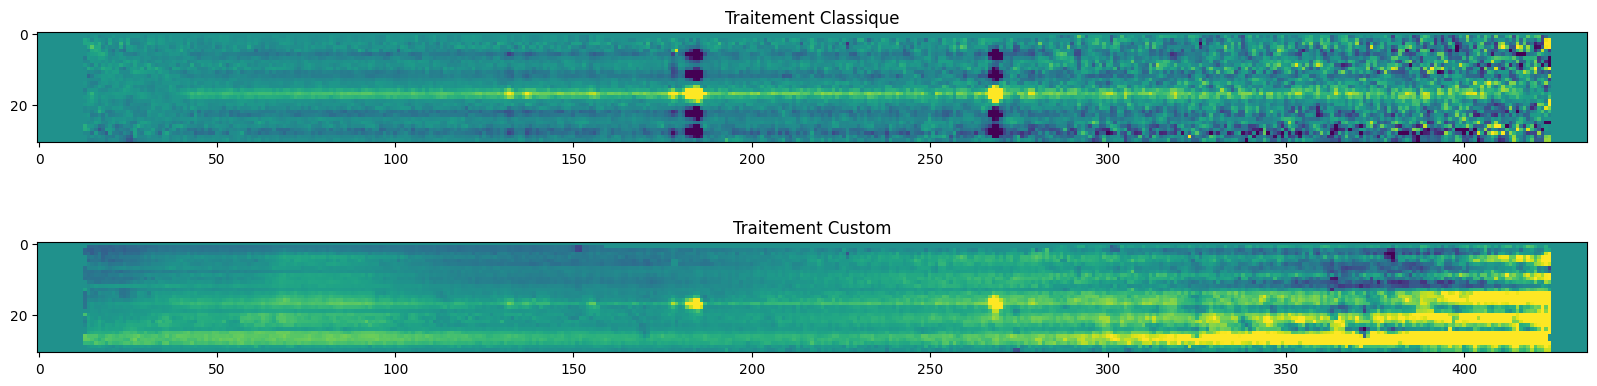

In [19]:
workingDir = "../mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/"
mastPath = workingDir + "Mast/jw01345-o063_s01699_nirspec_clear-prism_s2d.fits"
myPath = workingDir + "Final/jw01345-o063_s01699_nirspec_clear-prism_s2d.fits"
betterPath = workingDir + "BetterPolyn/jw01345-o063_s01699_nirspec_clear-prism_s2d.fits"

mastmos = dm.open(mastPath)
mastData = mastmos.data
    
mymos = dm.open(myPath)
myData = mymos.data

bettermos = dm.open(betterPath)
betterData = bettermos.data
    
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
z = ZScaleInterval()
z1, z2 = z.get_limits(mastData)
plt.imshow(mastData,vmin=z1,vmax=z2)
plt.title("Traitement Classique")

#plt.figure()
z = ZScaleInterval()
z1, z2 = z.get_limits(myData)
#plt.imshow(myData,vmin=z1,vmax=z2)
#plt.show()

plt.subplot(2,1,2)
#z = ZScaleInterval()
#z1, z2 = z.get_limits(betterData)
plt.imshow(betterData,vmin=z1,vmax=z2)
plt.title("Traitement Custom")
plt.show()


In [5]:
with dm.open(workingDir+"jw01345063001_03101_00001_nrs1_srctype.fits") as src:
    slits = src.slits

In [7]:
def extract_spectrum(slit,label,lamb=None):
    plt.figure()
    z = ZScaleInterval()
    z1, z2 = z.get_limits(slit.data)
    plt.imshow(slit.data,vmin=z1,vmax=z2)

    if lamb is None:
        lamb = slit.wavelength

    n = 3
    s_dec, s_ra = slit.source_dec, slit.source_ra
    x, y = slit.meta.wcs.transform("world", "detector", s_ra, s_dec, 3)
    plt.hlines((y + n, y - n), 0, slit.data.shape[1], color='r', linewidth=0.5, linestyle='dashed')
    print(y)

    wavelength = lamb[round(y) - n:round(y) + n, :]
    target = slit.data[round(y) - n:round(y) + n, :]
    err = slit.err[round(y) - n:round(y) + n, :]


    wavelength = wavelength.mean(axis=0)
    spectrum = target.mean(axis=0)
    # Usually, the error is dominated by the variance on the slice
    err = np.mean(err ** 2, axis=0) + target.var(axis=0)
    err = np.sqrt(err)

    # The spectrum plot
    plt.figure()
    plt.errorbar(wavelength, spectrum, yerr=err, marker='.', linewidth=0.3,label=label)
    plt.grid(True)
    plt.show()
    
    return wavelength, spectrum, err

14.309998466964771


<Figure size 640x480 with 0 Axes>

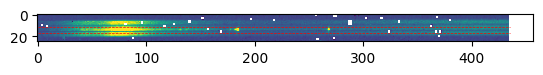

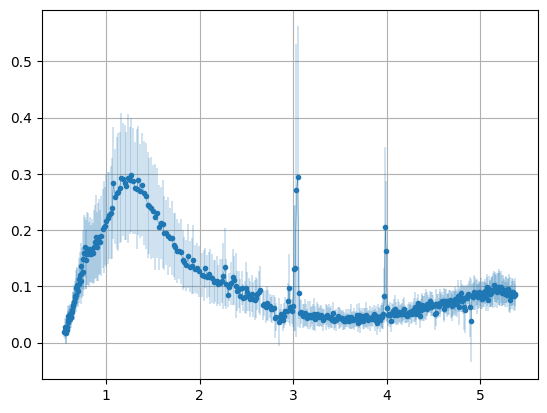

17.299729036440507


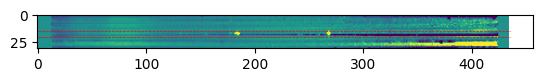

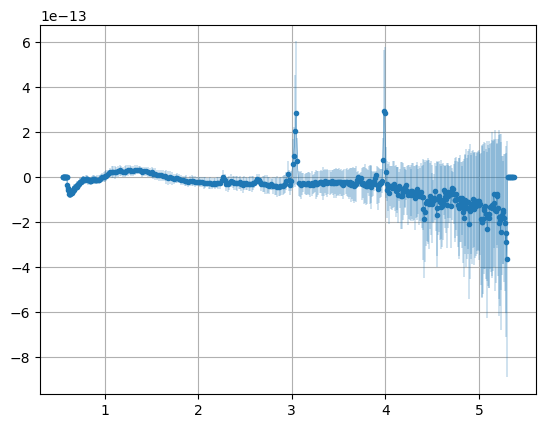

16.43027005296354


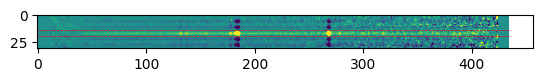

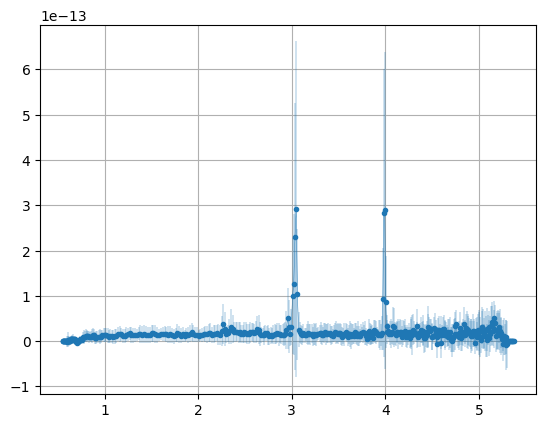

17.29972883073365


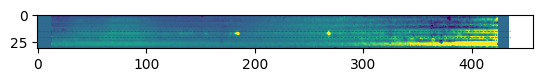

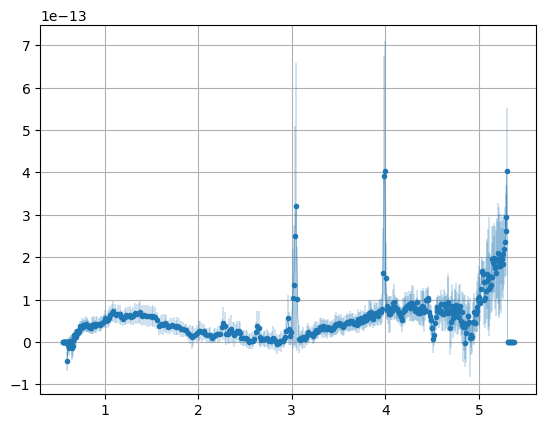

In [8]:
for slit in slits:
    if slit.name == "259":
        plt.figure()
        src_x, src_y, src_err = extract_spectrum(slit,"srctype")
        
        Y, X = np.indices(mymos.data.shape)
        ra, dec, lamb = mymos.meta.wcs.transform('detector', 'world', X, Y)
        my_x, my_y, my_err = extract_spectrum(mymos,"mydata",lamb=lamb)
        
        Y, X = np.indices(mastmos.data.shape)
        ra, dec, lamb = mastmos.meta.wcs.transform('detector', 'world', X, Y)
        mast_x, mast_y, mast_err = extract_spectrum(mastmos,"mast",lamb=lamb)
        
        Y, X = np.indices(bettermos.data.shape)
        ra, dec, lamb = bettermos.meta.wcs.transform('detector', 'world', X, Y)
        better_x, better_y, better_err = extract_spectrum(bettermos,"mast",lamb=lamb)


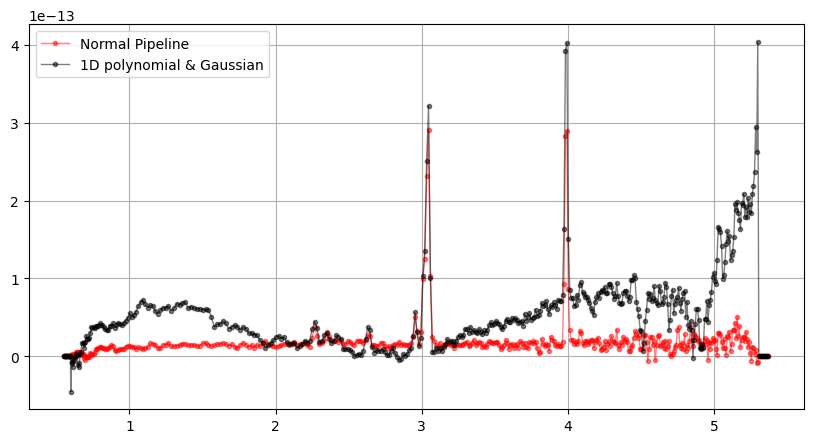

In [13]:
plt.figure(figsize=(10,5))
#plt.errorbar(src_x,src_y/src_y[~np.isnan(src_y)].mean(),yerr=src_err,color="k",marker='.',linewidth=1,label="Srctype")
#plt.errorbar(my_x,my_y,yerr=my_err,color="b",marker='.',linewidth=1,label="2D Polynomial",alpha=0.5,capsize=30)
plt.errorbar(mast_x,mast_y,color="r",marker='.',linewidth=1,label="Normal Pipeline",alpha=0.5)
plt.errorbar(better_x,better_y,color='k',marker='.',linewidth=1,label="1D polynomial & Gaussian",alpha=0.5)

#plt.xlim(3,3.1)
plt.grid()
plt.legend()
plt.show()

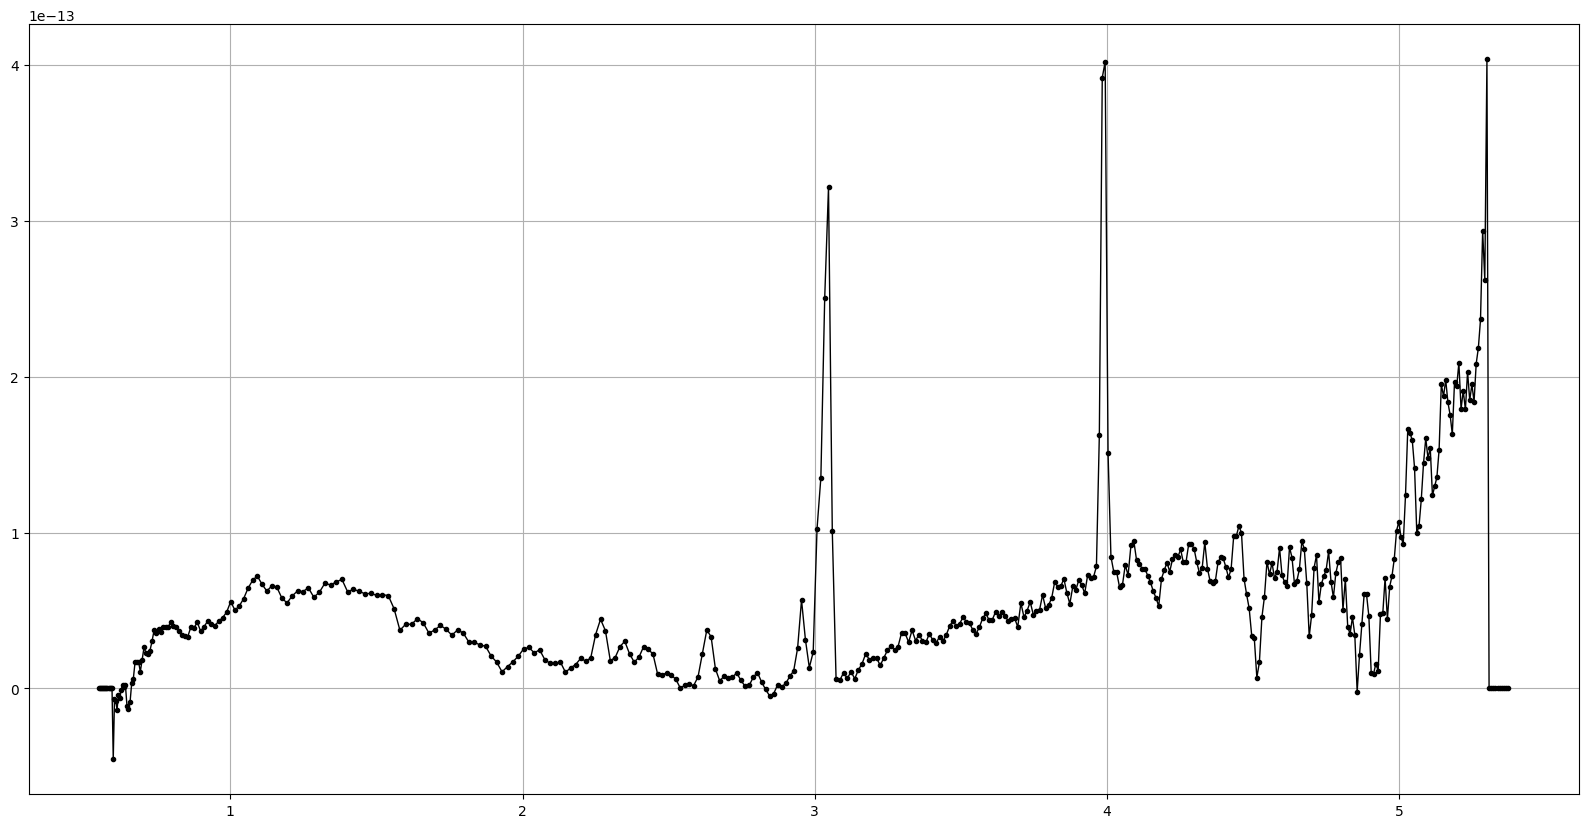

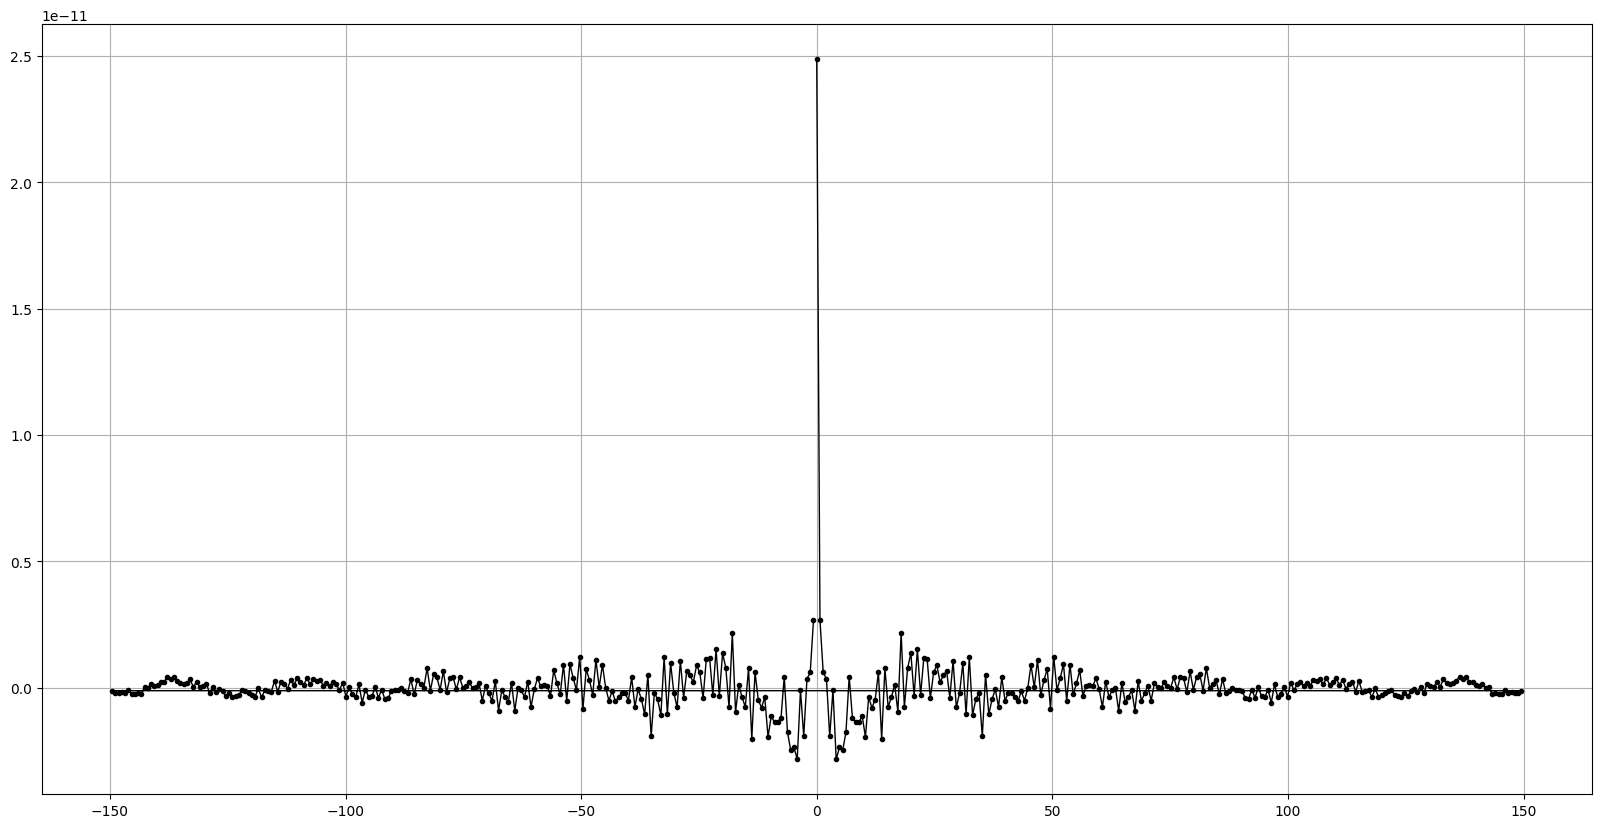

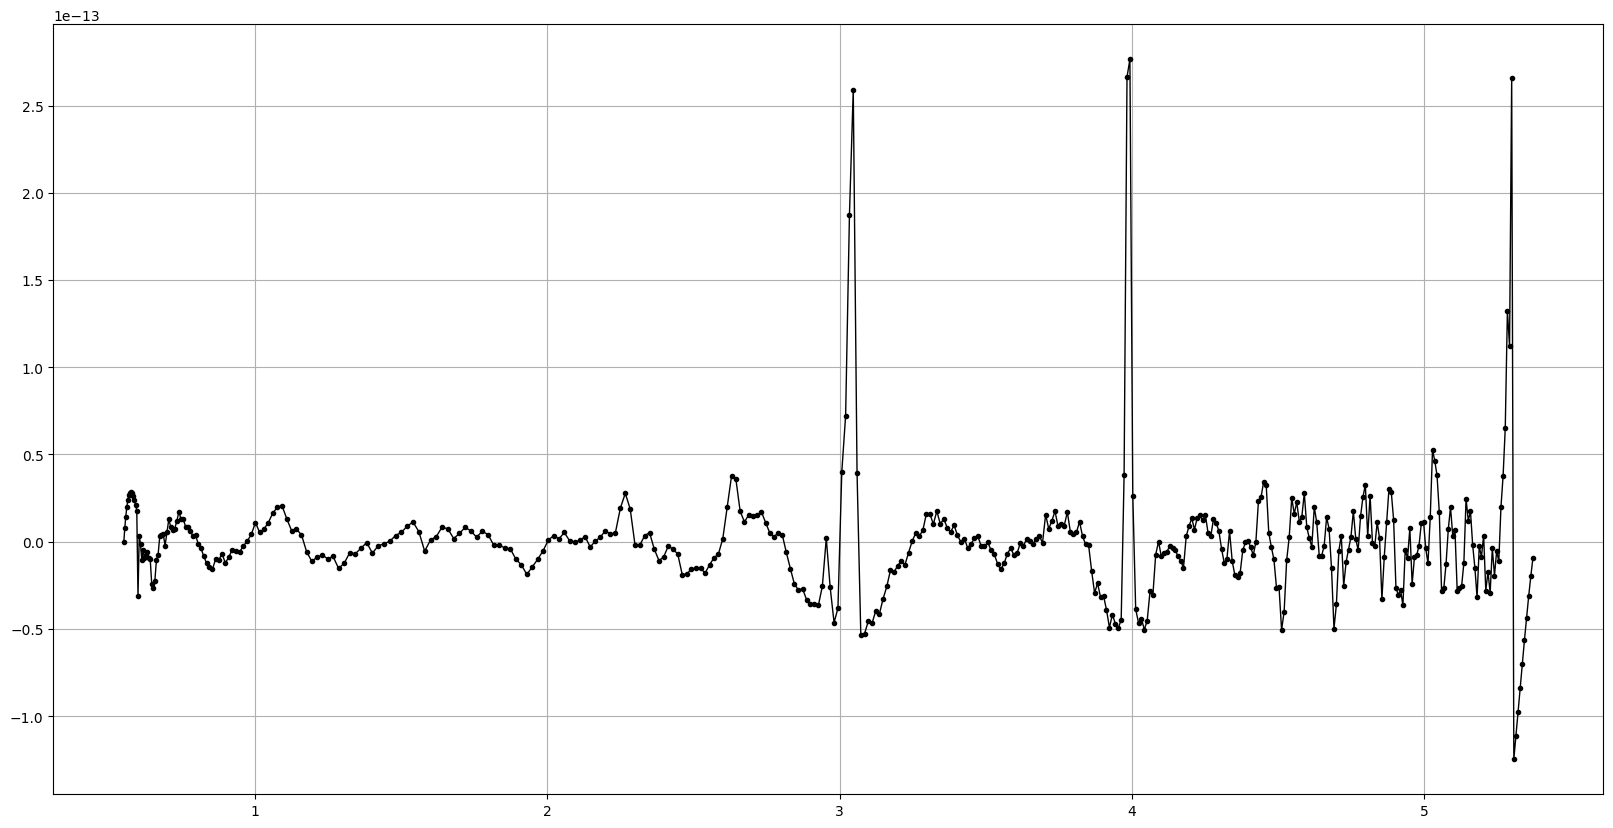

In [238]:
plt.figure(figsize=(20,10))
plt.plot(better_x,better_y,marker='.',linewidth=1,color='k')
plt.grid()
plt.show()


N = len(better_x)
fft = np.fft.fft(better_y)
q = np.fft.fftfreq(len(better_x),d=better_x[1] - better_x[0])

plt.figure(figsize=(20,10))
plt.plot(q,fft,marker='.',linewidth=1,color='k')
plt.grid()
plt.show()


fft[abs(q) < 10] = 0

y = np.fft.ifft(fft).real

plt.figure(figsize=(20,10))
plt.plot(better_x,y,marker='.',linewidth=1,color='k')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


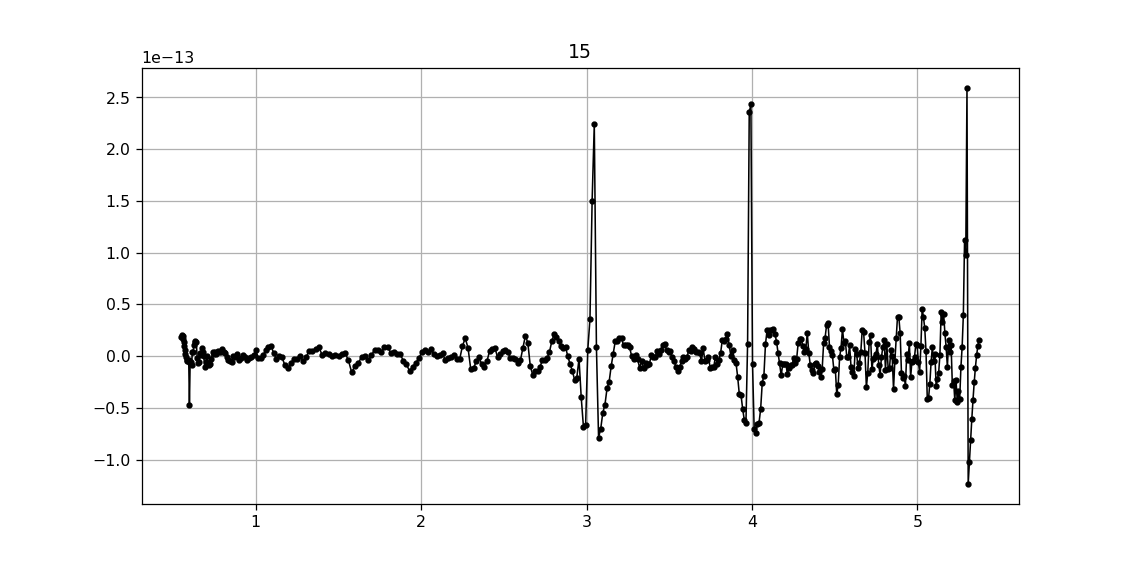

In [254]:
%matplotlib nbagg
fig, ax = plt.subplots(figsize=(10, 5))


def animate(cut):
    ax.clear()
    N = len(better_x)
    fft = np.fft.fft(better_y)
    q = np.fft.fftfreq(len(better_x), d=better_x[1] - better_x[0])
    fft[abs(q) < cut] = 0
    y = np.fft.ifft(fft).real
    ax.plot(better_x, y, marker='.', linewidth=1, color='k')
    ax.set_title(cut)
    ax.grid()

ani = FuncAnimation(fig, animate, frames=range(0, 140), interval=40)
plt.show()

<IPython.core.display.Javascript object>


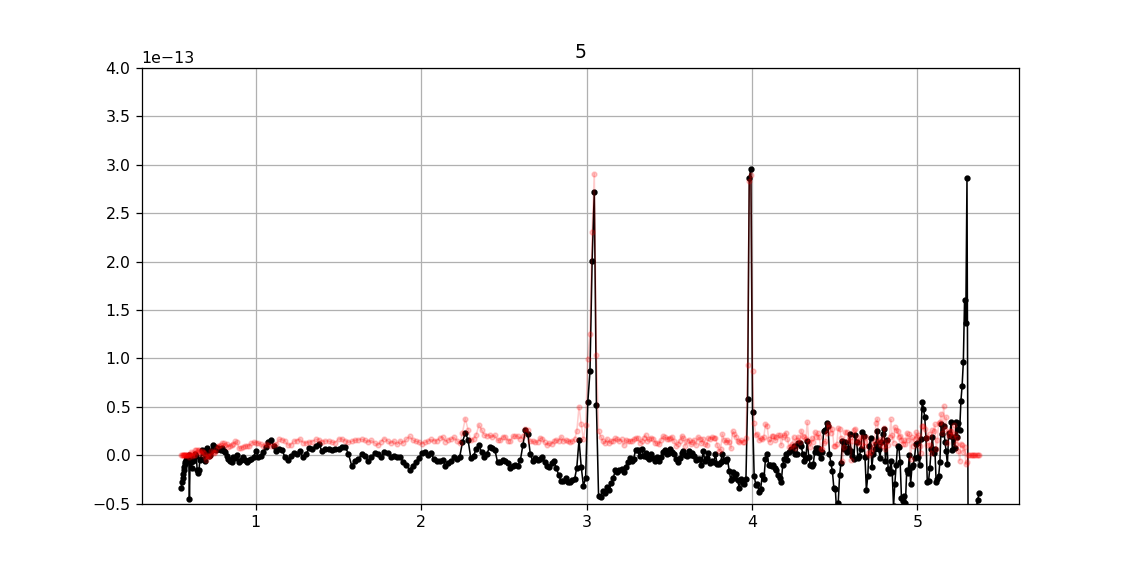

In [296]:
%matplotlib nbagg
fig, ax = plt.subplots(figsize=(10, 5))



def animate(cut):
    ax.clear()
    N = len(better_x)
    fft = np.fft.fft(better_y)
    q = np.fft.fftfreq(len(better_x), d=better_x[1] - better_x[0])
    
    s = cut
    fft = fft * (1 - np.exp(-q**2 / (2*s**2)))
    y = np.fft.ifft(fft).real
    ax.plot(better_x, y, marker='.', linewidth=1, color='k')
    ax.set_title(cut)
    ax.grid()
    ax.set_ylim(-0.5e-13,4e-13)
    plt.plot(mast_x,mast_y,color="r",marker='.',linewidth=1,label="Normal Pipeline",alpha=0.2)
    


ani = FuncAnimation(fig, animate, frames=range(0, 20), interval=40)
plt.show()

In [8]:
def gaussian(x,x0,A,s):
    """
    Simple gaussian function
    """
    return A * np.exp(-(x-x0)**2 / (2*s**2))

"""
Slitlet model : 3 gaussians of same sigma
"""
def slitletModel(x,x1,x2,x3,A1,A2,A3,s,c):
    return gaussian(x,x1,A1,s) + gaussian(x,x2,A2,s) + gaussian(x,x3,A3,s) + c

    
def smartRound(x,signal):
    x_low = int(x)
    x_high = x_low + 1
    
    if signal[x_low] < signal[x_high]:
        return x_low
    else:
        return x_high

1x1


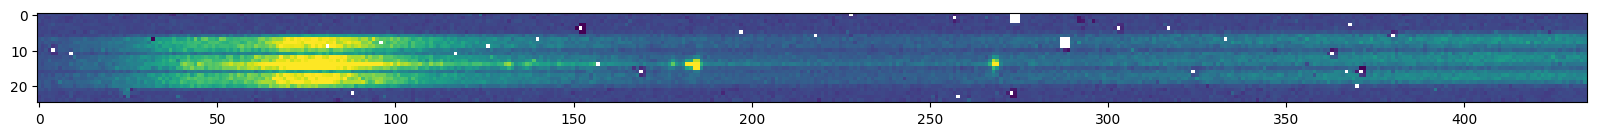

In [9]:
for slit in slits:
    if slit.name == "259":
        data = np.ma.masked_invalid(slit.data)
        print(slit.shutter_state)
plt.figure(figsize=(20,4))
z = ZScaleInterval()
z1, z2 = z.get_limits(data)
plt.imshow(data,vmin=z1,vmax=z2)
plt.show()

[ 8 14 19]
[ 7.99959712 13.07364154 17.7994426 ]
2.537022207545198 2.362900532802545
[[ 5 10]
 [10 16]
 [16 21]]


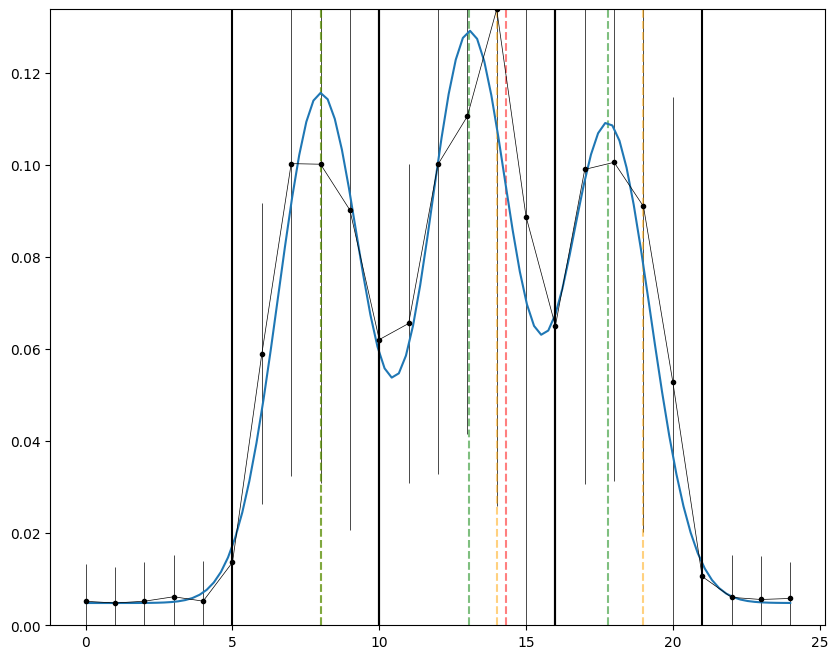

In [10]:
horiz_sum = np.mean(data,axis=1)
horiz_err = np.std(data,axis=1)
hmax = horiz_sum.max()
x = range(len(horiz_sum))

plt.figure(figsize=(10,8))
plt.ylim(0,hmax)
plt.errorbar(x,horiz_sum,yerr=horiz_err,color='k',marker='.',linewidth=0.5)
plt.vlines(14.3099,0,hmax,color='r',linestyle='dashed',alpha=0.5)

peaks = []
j = 2
while not len(peaks) == 3:
    if j > 6:
        break
    peaks = find_peaks_cwt(horiz_sum,j)
    j += 1

print(peaks)
plt.vlines(peaks,0,hmax,color='orange',linestyle="dashed",alpha=0.5)
    

coeff, err = cfit(slitletModel, x, horiz_sum, sigma=horiz_err, p0=[*peaks,*horiz_sum[peaks],0.5,0])
peaks = np.array(coeff[:3])
peaks = np.sort(peaks)

print(peaks)
plt.vlines(peaks,0,hmax,color='green',linestyle="dashed",alpha=0.5)

X = np.linspace(0,x[-1],100)
plt.plot(X,slitletModel(X,*coeff))

d1 = (peaks[1] - peaks[0])/2
d2 = (peaks[2] - peaks[1])/2

print(d1,d2)

xmin = np.array([smartRound(max(0,peaks[0]-d1),horiz_sum),
                 smartRound(peaks[1]-d1,horiz_sum),
                 smartRound(peaks[2]-d2,horiz_sum)])

xmax = np.array([smartRound(peaks[0]+d1,horiz_sum), 
                 smartRound(peaks[1]+d2,horiz_sum), 
                 smartRound(min(x[-1],peaks[2]+d2),horiz_sum)])

slice_indices = np.array([xmin,xmax]).T
print(slice_indices)

plt.vlines(slice_indices.ravel(),0,hmax,color='k')



plt.show()

In [150]:
def betterPolynomial(X,s,y0,*coeffs):
    """
    We admit the convention that x is the horizontal direction, y the vertical direction
    Returns a 2D array, where the profile along Y is a gaussian, and the profile along X is a polynomial
    Those 2 profiles are then multiplied together

    Parameters
    ----------
    X : [x,y]
    s : gaussian sigma
    y0 : gaussian position
    coeffs : m=n+1 coeffs of the polynomial. We assume that coeffs[i] is such that we have coeffs[i] * x**i

    Returns
    -------
    2D array
    """
    coeffs = np.array(coeffs)
    x,y = X

    # gaussian
    img = np.exp(-(y0-y)**2/(2*s**2))

    # repeat m times the X 2D array along 1st axis
    m = len(coeffs)
    x = x[np.newaxis, :, :]
    x = np.repeat(x, m, axis=0)

    # Make power series to the right shape
    power = np.arange(m)
    power = power[:, np.newaxis, np.newaxis]

    # Take the power along the 1st axis, multiply by coeffs along the same axis, sum along the axis
    polyn = np.power(x,power)
    polyn = polyn * coeffs[:, None, None]
    polyn = polyn.sum(axis=0)

    img = img * polyn
    return img.ravel()